In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'MLPModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MLPModel(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = MLPModel().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 3777


In [13]:
# Train model
model, history = sf.train_model(
    model=model,
    dataset_train=subsets['train'],
    dataset_val=subsets['val'],

    # Define loss & optimizer
    loss_function=nn.MSELoss().to(device),
    optimizer=optim.Adam(params=model.parameters(), lr=0.01),

    # Define computing device
    device=device,

    # Define training parameters
    epochs=20,
    patience=3,
    delta=0,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    pin_memory=True,

    # Define save locations
    save_state_dict_as=f'../models/{model_name}/state_dict.pt',
    save_history_as=f'../models/{model_name}/history.csv'
    )

100%|██████████| 646/646 [00:00<00:00, 1528.60it/s]


Epoch  1/20: RMSE_train: 1,306,177, RMSE_val: 1,275,828


100%|██████████| 646/646 [00:00<00:00, 1853.81it/s]


Epoch  2/20: RMSE_train: 871,645, RMSE_val: 1,096,406


100%|██████████| 646/646 [00:00<00:00, 1745.90it/s]


Epoch  3/20: RMSE_train: 811,611, RMSE_val: 992,574


100%|██████████| 646/646 [00:00<00:00, 1512.33it/s]


Epoch  4/20: RMSE_train: 790,425, RMSE_val: 963,875


100%|██████████| 646/646 [00:00<00:00, 1955.41it/s]


Epoch  5/20: RMSE_train: 779,918, RMSE_val: 952,867


100%|██████████| 646/646 [00:00<00:00, 1950.47it/s]


Epoch  6/20: RMSE_train: 773,750, RMSE_val: 946,863


100%|██████████| 646/646 [00:00<00:00, 1845.84it/s]


Epoch  7/20: RMSE_train: 769,780, RMSE_val: 945,269


100%|██████████| 646/646 [00:00<00:00, 1876.81it/s]


Epoch  8/20: RMSE_train: 766,858, RMSE_val: 937,226


100%|██████████| 646/646 [00:00<00:00, 1957.30it/s]


Epoch  9/20: RMSE_train: 764,274, RMSE_val: 937,302
EarlyStopping counter: 1 out of 3


100%|██████████| 646/646 [00:00<00:00, 1951.52it/s]


Epoch 10/20: RMSE_train: 762,318, RMSE_val: 936,783


100%|██████████| 646/646 [00:00<00:00, 1585.79it/s]


Epoch 11/20: RMSE_train: 760,096, RMSE_val: 935,912


100%|██████████| 646/646 [00:00<00:00, 1801.54it/s]


Epoch 12/20: RMSE_train: 758,597, RMSE_val: 928,500


100%|██████████| 646/646 [00:00<00:00, 1909.03it/s]


Epoch 13/20: RMSE_train: 757,283, RMSE_val: 929,388
EarlyStopping counter: 1 out of 3


100%|██████████| 646/646 [00:00<00:00, 1757.35it/s]


Epoch 14/20: RMSE_train: 755,869, RMSE_val: 938,103
EarlyStopping counter: 2 out of 3


100%|██████████| 646/646 [00:00<00:00, 1953.82it/s]


Epoch 15/20: RMSE_train: 754,601, RMSE_val: 923,403


100%|██████████| 646/646 [00:00<00:00, 1812.83it/s]


Epoch 16/20: RMSE_train: 753,161, RMSE_val: 925,729
EarlyStopping counter: 1 out of 3


100%|██████████| 646/646 [00:00<00:00, 1941.20it/s]


Epoch 17/20: RMSE_train: 752,127, RMSE_val: 912,938


100%|██████████| 646/646 [00:00<00:00, 1890.25it/s]


Epoch 18/20: RMSE_train: 751,626, RMSE_val: 918,273
EarlyStopping counter: 1 out of 3


100%|██████████| 646/646 [00:00<00:00, 1881.72it/s]


Epoch 19/20: RMSE_train: 750,622, RMSE_val: 909,686


100%|██████████| 646/646 [00:00<00:00, 1974.26it/s]

Epoch 20/20: RMSE_train: 749,599, RMSE_val: 912,451
EarlyStopping counter: 1 out of 3


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset        RMSE         MAE   MAPE     R2
--------------------------------------------
train   748719.879  424848.460  0.609  0.640
val     912970.471  508925.953  0.721  0.456
test    916958.863  510669.693  0.691  0.457
--------------------------------------------
total   802444.712  450419.311  0.636  0.586


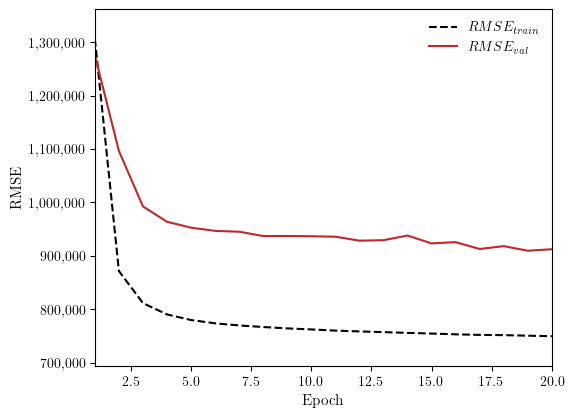

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

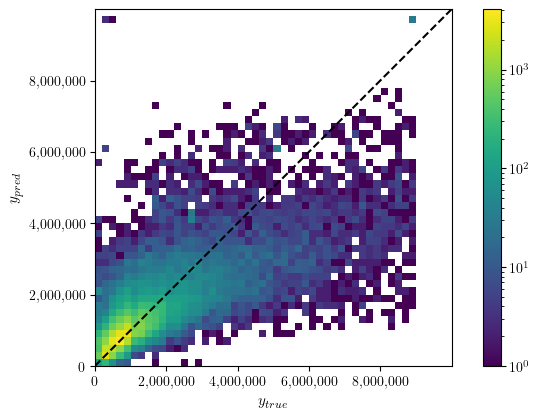

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')